In [9]:
import pandas as pd
import xgboost as xgb
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics 
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import r2_score
import joblib
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
from hyperopt.pyll.base import scope
from hyperopt.pyll.stochastic import sample
random_state = 42

In [10]:
df = pd.read_csv('../data/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [11]:
df['sex'] = df['sex'].apply({'male' :0, 'female' :1}.get)
df['smoker'] = df['smoker'].apply({'yes' :1, 'no' :0}.get)
df['region'] = df['region'].apply({'southwest' :1, 'southeast' :2, 'northwest' :3 , 'northeast' :4}.get)

In [12]:
X = df.drop('charges', axis = 1)
y = df['charges']
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state = random_state)

In [13]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled= scaler.transform(X_train)
X_test_scaled= scaler.transform(X_test)

#czy skalować ? 

In [53]:
XGB_model = xgb.XGBRegressor(max_depth = 3, n_estimators=50, learning_rate =.2,objective='reg:squarederror')
XGB_model.fit(X_train, y_train);

In [15]:
def show_metrics(model,x_test,y_test):
    y_pred = model.predict(x_test)
    MAE_XGB= metrics.mean_absolute_error(y_test, y_pred)
    MSE_XGB = metrics.mean_squared_error(y_test, y_pred)
    RMSE_XGB =np.sqrt(MSE_XGB)
    R2_XGB_perc = (metrics.r2_score(y_test, y_pred))*100
    print("RMSE: {:.4f}, R2: {:.2f}%, MSE: {:.4f}".format(RMSE_XGB,R2_XGB_perc,MSE_XGB))

In [16]:
show_metrics(XGB_model,X_test,y_test)

RMSE: 4542.0406, R2: 85.92%, MSE: 20630132.7660


In [17]:
scores = cross_val_score(XGB_model, X_train, y_train, cv=5)
print(np.sqrt(scores))

[0.94819722 0.93530789 0.89704753 0.90296387 0.90987528]


In [18]:
feats = df.columns.to_list()

In [19]:
import scikitplot as skplt
def plot_feature_importances(model, feat_list):

    model_name = type(model).__name__
    skplt.estimators.plot_feature_importances(model, feature_names=df[feat_list].columns,
                                            title=f'{model_name} feature importances')
    plt.xticks(rotation=90)

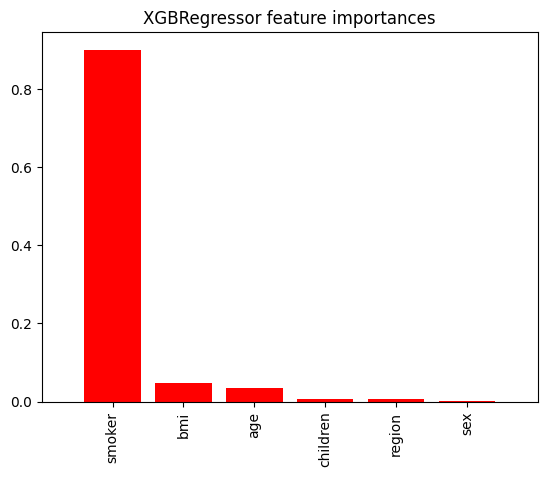

In [20]:
plot_feature_importances(XGB_model,feats)

In [21]:
kf = KFold(n_splits=5, shuffle=True, random_state=random_state)

In [30]:

def run_xgb_hyperopt(x_train, y_train, x_test,y_test, cv, max_evals, random_state):
    
    # funkcja, której wynik chcemy minimalizować (RMSE)
    def objective(space):
        XGB_model = xgb.XGBRegressor(
        learning_rate=space['learning_rate'],
        n_estimators=int(space['n_estimators']),
        max_depth=int(space['max_depth']),
        min_child_weight=int(space['min_child_weight']),
        gamma=space['gamma'],
        subsample=space['subsample'],
        colsample_bytree=space['colsample_bytree'],
        reg_alpha=space['reg_alpha'],
        reg_lambda=space['reg_lambda'],
        objective='reg:squarederror',
        random_state = random_state
    )
               
        XGB_model.fit(x_train, y_train, verbose=False)
        y_pred = XGB_model.predict(x_test)

        rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
            
        print("RMSE: {:.4f}".format(rmse))
        return{'loss': rmse, 'status': STATUS_OK }
    
    # parametry do optymizacji    
    space = {
    'learning_rate': hp.quniform('learning_rate', 0.01, 0.3, 0.01),
    'n_estimators': hp.quniform('n_estimators', 100, 1000, 1),
    'max_depth': hp.quniform('max_depth', 2, 20, 1),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'gamma': hp.quniform('gamma', 0.0, 1.0, 0.01),
    'subsample': hp.quniform('subsample', 0.1, 1.0, 0.01),
    'colsample_bytree': hp.quniform('colsample_bytree', 0.1, 1.0, 0.01),
    'reg_alpha': hp.loguniform('reg_alpha', -5, 0),
    'reg_lambda': hp.loguniform('reg_lambda', -5, 0)
    }

    trials = Trials() # przechowuje info dla kazdego kroku.
    
    best = fmin(fn=objective , #fmin - funkcja, ktora chcemy minimalizowac
                space=space, #przestrzeń potencjalnych (hyper)parametrów
                algo=tpe.suggest, #algorytm wyszukujacy najlepsze parametry
                max_evals=max_evals, #ilość prób
                trials=trials) #zapisywane wynikow w trakcie
    
    hyperparams = space_eval(space, best)

    print("The best params: ", hyperparams)
    return hyperparams

In [31]:
x_train_v = X_train.values
y_train_v = y_train.values
x_test_v = X_test.values
y_test_v = y_test.values


In [32]:
best_XGB = run_xgb_hyperopt(x_train_v,y_train_v,x_test_v,y_test_v,cv=kf,max_evals=5000, random_state = random_state)

RMSE: 5918.7879                                         
RMSE: 7242.7749                                                                  
RMSE: 6178.0925                                                                  
RMSE: 7466.1824                                                                  
RMSE: 4606.0906                                                                  
RMSE: 6421.3827                                                                  
RMSE: 9527.8303                                                                  
RMSE: 5402.9957                                                                  
RMSE: 5424.7601                                                                  
RMSE: 6568.5366                                                                  
RMSE: 6058.9194                                                                   
RMSE: 5652.1441                                                                   
RMSE: 4834.7445                        

In [40]:
best_XGB 

{'colsample_bytree': 0.97,
 'gamma': 0.12,
 'learning_rate': 0.01,
 'max_depth': 3.0,
 'min_child_weight': 5.0,
 'n_estimators': 423.0,
 'reg_alpha': 0.018634811484198422,
 'reg_lambda': 0.011160725546019646,
 'subsample': 0.3}

In [62]:
best_XGB

{'colsample_bytree': 0.97,
 'gamma': 0.12,
 'learning_rate': 0.01,
 'max_depth': 3.0,
 'min_child_weight': 5.0,
 'n_estimators': 423.0,
 'reg_alpha': 0.018634811484198422,
 'reg_lambda': 0.011160725546019646,
 'subsample': 0.3}

In [78]:
XGB_model_tuned = xgb.XGBRegressor(max_depth = 3, min_child_weight = 5, n_estimators = 423, reg_alpha = 0.018634811484198422, reg_lambda = 0.011160725546019646,subsample = 0.3, colsample_bytree = 0.97,gamma = 0.12,learning_rate = 0.01)

In [79]:
XGB_model_tuned.fit(X_train,y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.97, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.12, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             n_estimators=423, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [80]:
y_pred_XGB = XGB_model_tuned.predict(X_test)

In [81]:
np.sqrt(metrics.mean_squared_error(y_test,y_pred_XGB))

4382.386124217193

In [82]:
show_metrics(XGB_model_tuned,X_test,y_test)

RMSE: 4382.3861, R2: 86.89%, MSE: 19205308.1417


In [83]:
joblib.dump(XGB_model_tuned,'joblib_model_xgb')

['joblib_model_xgb']

In [84]:
model = joblib.load('joblib_model_xgb')

In [85]:
data = {'age' : 40,
        'sex' : 1,
        'bmi' : 40.30,
        'children' : 4,
        'smoker' : 1,
        'region' : 2}
data = pd.DataFrame(data,index=[0])

In [86]:
data 

,age,sex,bmi,children,smoker,region
0,40,1,40.3,4,1,2


In [87]:
model.predict(data)

array([42157.27], dtype=float32)